In [2]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [3]:
#Data Preprocessing

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float')/255.
x_test  = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784))
x_test  = np.reshape(x_test, (10000, 784))

11493376/11490434 [==============================] - 8s 1us/step


In [4]:
#Adding Noise
x_train_noisy = x_train + np.random.rand(60000, 784)*0.9
x_test_noisy  = x_test + np.random.rand(10000, 784)*0.9
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy  = np.clip(x_test_noisy, 0., 1.)

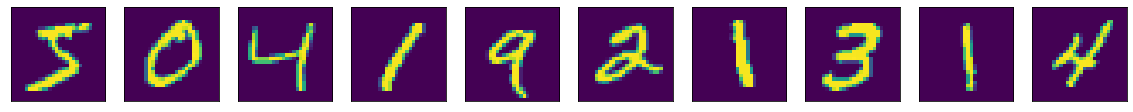

In [5]:
def Plot(x, p, labels = False):
    plt.figure(figsize = (20, 2))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(x[i].reshape(28,28), cmap = 'viridis')
        plt.xticks([])
        plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i]))
    plt.show()
    
Plot(x_train, None)

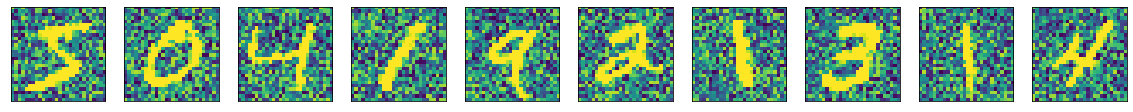

In [6]:

Plot(x_train_noisy, None)

In [7]:
#Building and Training a Classifier

classifier = Sequential([
    Dense(256, activation = 'relu', input_shape = (784,)),
    Dense(256, activation = 'relu'),
    Dense(256, activation = 'softmax')
])

classifier.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

classifier.fit(x_train, y_train, batch_size = 512, epochs = 3)

Epoch 1/3
118/118 [==============================] - 2s 10ms/step - loss: 0.7359 - accuracy: 0.8214
Epoch 2/3
118/118 [==============================] - 1s 10ms/step - loss: 0.1954 - accuracy: 0.9437
Epoch 3/3
118/118 [==============================] - 1s 10ms/step - loss: 0.1379 - accuracy: 0.9604


In [8]:
loss, acc = classifier.evaluate(x_test, y_test)

print(acc)

313/313 [==============================] - 0s 838us/step - loss: 0.1215 - accuracy: 0.9642
0.9642000198364258


In [9]:
loss, acc = classifier.evaluate(x_test_noisy, y_test)

print(acc)

313/313 [==============================] - 0s 854us/step - loss: 10.0566 - accuracy: 0.1832
0.18320000171661377


In [10]:
#Autoencoder

input_image = Input(shape = (784,))
encoded = Dense(64, activation = 'relu')(input_image)
decoded = Dense(784, activation = 'sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [11]:
#Training the Autoencoder

autoencoder.fit(
    x_train_noisy, 
    x_train,
    epochs = 100,
    batch_size = 512,
    validation_split = 0.2,
    verbose = False,
    callbacks = [
        EarlyStopping(monitor = 'val_loss', patience = 5),
        LambdaCallback(on_epoch_end = lambda e,l: print('{:.3f}'.format(l['val_loss']), end = ' _ '))
    ]
)

print(' _ ')
print('Training is complete!')

0.258 _ 0.227 _ 0.204 _ 0.186 _ 0.175 _ 0.165 _ 0.158 _ 0.152 _ 0.147 _ 0.142 _ 0.138 _ 0.135 _ 0.132 _ 0.129 _ 0.127 _ 0.125 _ 0.123 _ 0.122 _ 0.120 _ 0.119 _ 0.118 _ 0.117 _ 0.117 _ 0.116 _ 0.115 _ 0.115 _ 0.114 _ 0.114 _ 0.113 _ 0.113 _ 0.113 _ 0.113 _ 0.112 _ 0.112 _ 0.112 _ 0.112 _ 0.112 _ 0.112 _ 0.112 _ 0.112 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _  _ 
Training is complete!


In [12]:
#Denoised Images

preds = autoencoder.predict(x_test_noisy)

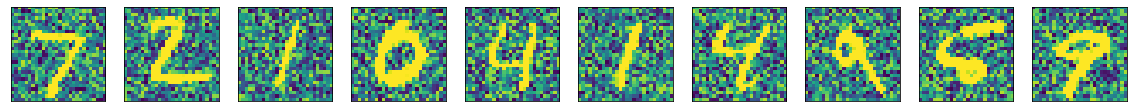

In [14]:
Plot(x_test_noisy, None)

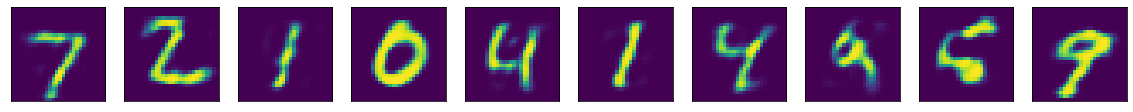

In [15]:
Plot(preds, None)

In [16]:
#accuracy
loss, acc = classifier.evaluate(preds, y_test)
print(acc)

313/313 [==============================] - 0s 803us/step - loss: 0.1938 - accuracy: 0.9395
0.9394999742507935


In [17]:
#Composite Model

input_image=Input(shape=(784,))
x=autoencoder(input_image)
y=classifier(x)

denoise_and_classfiy = Model(input_image, y)

In [18]:
predictions=denoise_and_classfiy.predict(x_test_noisy)

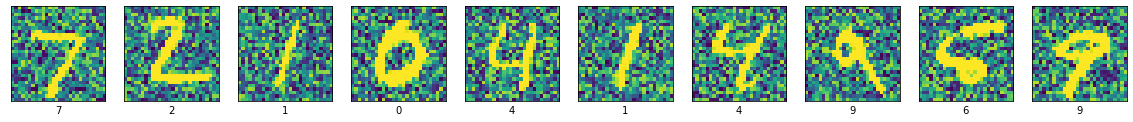

In [19]:
Plot(x_test_noisy, predictions, True)

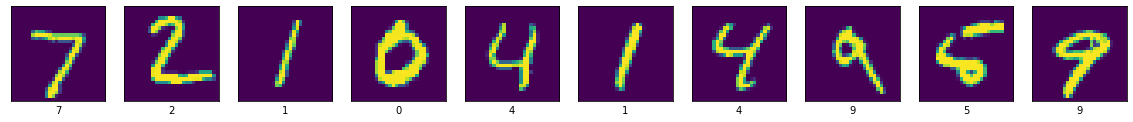

In [20]:
Plot(x_test, to_categorical(y_test), True)